In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand

# Q1) Show that when correctly viewed, these triples lie along a set of planes (I get about 30) and so are very much not randomly distributed in space. Do you see the same thing happen with python's random number generator? If possible, can you see the same effect on your local machine? 

In [2]:
# Load in 'random' data

x,y,z = np.loadtxt('rand_points.txt').T

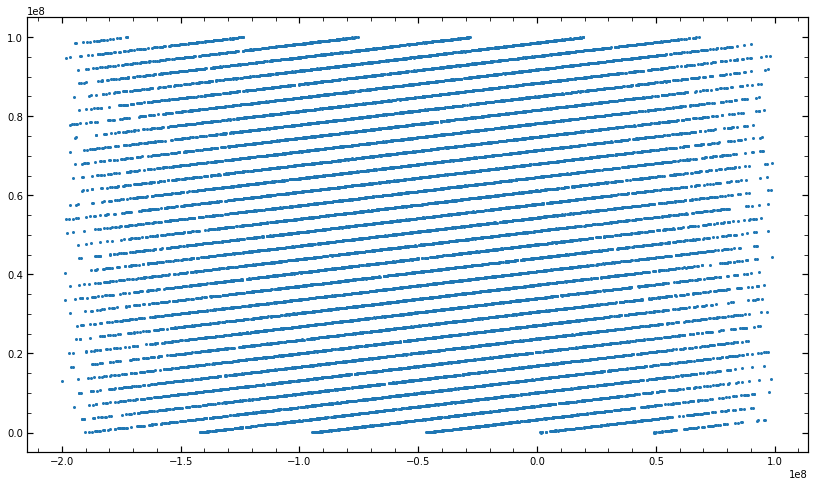

In [3]:
a = -2
b = 1
fig, ax = plt.subplots(figsize=[14,8])
ax.plot(a*x+b*y, z, '.', markersize=4.0);

After setting $a=-2$, $b=1$ and plotting $z$ against $ax+by$, a very obvious pattern was produced similar to the series of planes described in the question.

Now I will test this on my local machine, and see if I can reproduce a similar pattern.

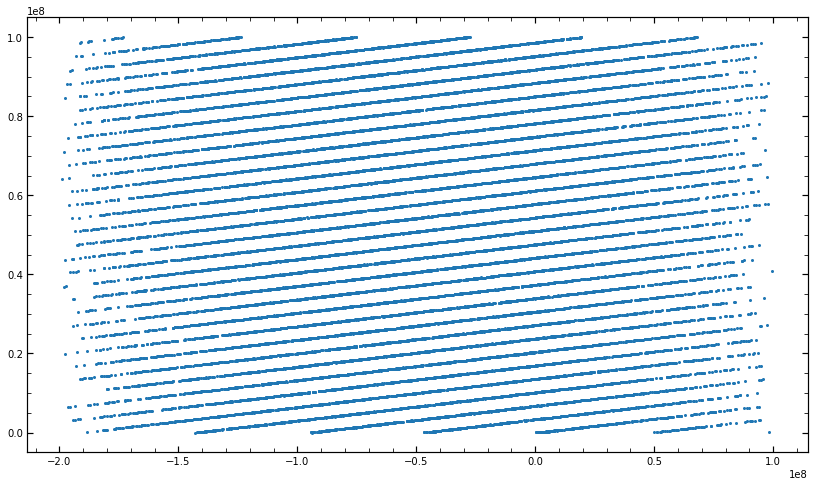

In [4]:
x1,y1,z1 = np.loadtxt('rand_points_local.txt').T
a = -2
b = 1
fig, ax = plt.subplots(figsize=[14,8])
ax.plot(a*x1+b*y1, z1, '.', markersize=4.0);

The same plane-pattern is observed. Now using the random number generator from Python, we can see if the same effect is produced. I used the same code from the `test_broken_libc.py` script, although modified it to use the RNG from the Python `random` module.

In [5]:
def get_rands(num,lower=0,upper=2**31):
    rands = np.zeros(num)
    for i in range(num):
        rands[i] = rand.randint(lower,upper)
    return rands

n=10000
vec=get_rands(n*3)
vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

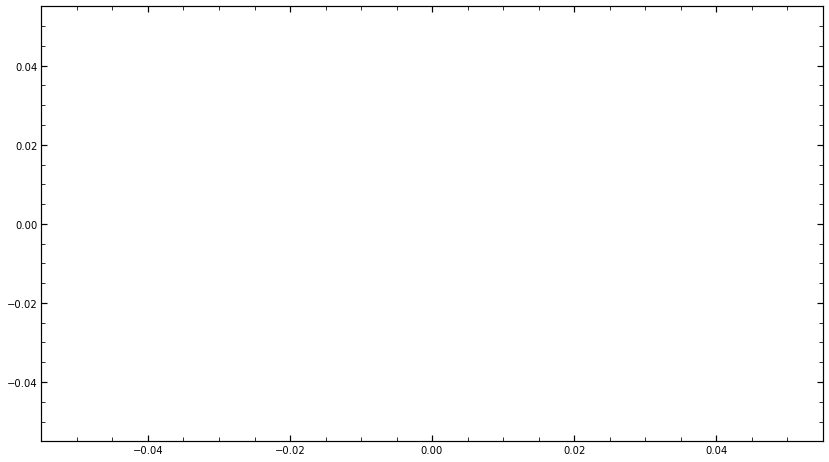

In [6]:
x2,y2,z2 = vv2.T
a = -2
b = 1
fig, ax = plt.subplots(figsize=[14,8])
ax.plot(a*x2+b*y2, z2, '.', markersize=7.0);

There does not appear to be any pattern/structure to the random numbers, indicating that they are in fact random.

# Q2) Now write a rejection method to generate exponential deviates from another distribution. Which of Lorentzians, Gaussians, and power laws could you use for the bounding distribution. You can assume exponential deviates are non-negative (cut off distribution at zero). Show that a histogram of your deviates matches up with the expected exponential curve. How efficient can you make this generator, in terms of the fraction of uniform deviates that give rise to an exponential deviate.

We can draw random numbers from an upper-bounding distribution, and then check if it falls within the bounded distribution. Therefore, if we want to generate exponential deviates using another distribution, we would require a distribution that bounds the exponential from above.

In [7]:
# Define functions to potentially bound exponential functions

def exp(x, lam=1):
    return lam*np.exp(-lam*x)

def gaussian(x, mu=0, sig=1):
    return np.exp(-(mu-x)**2 /(2*sig**2))

def lorentz(x):
    return 1/(1+x**2)

def power_law(x,C=1,a=1):
     return C*x**(-a)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  del sys.path[0]


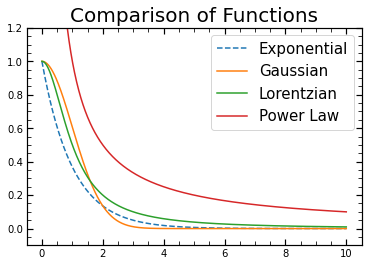

In [8]:
# Plot functions to check bounding ability

xx = np.linspace(0,10,1000) # Define interval from 0 onwards (cut off distribution at zero)

plt.plot(xx, exp(xx), linestyle = '--', label='Exponential')
plt.plot(xx, gaussian(xx), label='Gaussian')
plt.plot(xx, lorentz(xx), label='Lorentzian')
plt.plot(xx, power_law(xx), label='Power Law')
plt.ylim(ymin=-0.1, ymax=1.2)
plt.legend(fontsize=15)
plt.title('Comparison of Functions', fontsize=20);

Clearly, the Gaussian decays too rapidly to bound the exponential from above, and therefore, we cannot generate exponential deviates from a Gaussian. The Lorentzian and Power Law however, are able to bound the exponential from above. The issue of invertibility of the Power Law CDF favours the Lorentzian which is easily invertible (as we saw in class), and therefore we will use the Lorentzian to generate exponential deviates.

We can use the rejection sampling algorithm to obtain exponential deviates from a Lorentzian as follows;

1. Obtain a sample $y$ from the inverse CDF of the Lorentzian and a sample $u$ from a uniform distribution on the interval [0,1].
2. Check if $u < e^{-y} / (M (1+y^2)^{-1})$ for some scaling value $M$ used to ensure the bounding of the exponential from above (in this case we can set to 1). If this is true, accept $y$ as a sample from the exponential. If false, reject the value of $y$.

For the case of generating exponential deviates from a Lorentzian, we can use the fact that the CDF of the Lorentzian PDF is, 

\begin{equation}
\text{CDF}(x) = \text{arctan}(x) \implies \text{CDF}^{-1}(y) = \text{tan}(\pi(x-0.5))
\end{equation}

so we can use this analytic form of the inverse CDF of the Lorentzian to generate Lorentzian deviates to subsequently generate exponential deviates.

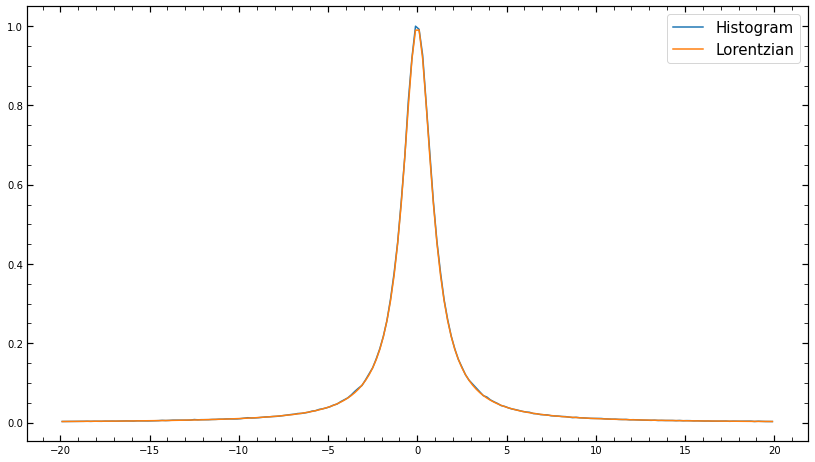

In [10]:
def lorentz_dev(n): # inverse CDF of Lorentztian, from class code
    x=np.random.rand(n)
    return np.tan(np.pi*(x-0.5))

def exp_from_lorentz(y, M=1): # modeled function after class example
    accept_prob=exp(y)/(M*lorentz(y)) # ratio of PDFs
    assert(np.max(accept_prob)<=1) # must be < 1 as exp(x) < lorentz(x) for method to work
    u=np.random.rand(len(accept_prob)) # sample uniform distribution
    accept=u<accept_prob
    return y[accept] # accept y as sample drawn from exponential

n=1000000
lorentz_devs=lorentz_dev(n) # draw samples from the CDF of lorentzian
lorentz_devs_thresh=lorentz_devs[np.abs(lorentz_devs)<20] # apply cutoff as we did in class to center (so symmetric)

vals,bin_edges=np.histogram(lorentz_devs_thresh,200) # bin samples
bin_centers=0.5*(bin_edges[1:]+bin_edges[:-1])

fig, ax = plt.subplots(figsize=[14,8])
ax.plot(bin_centers,vals/vals.max(), label='Histogram')
ax.plot(bin_centers,lorentz(bin_centers), label='Lorentzian')
ax.legend(fontsize=15);

Clearly, the two curves match very well, however, to confirm the deviates follow the expected exponential inverse CDF, we can plot the histogram of our deviates against the expected exponential curve.

The exponential's inverse CDF is defined below, and is obtained by simply taken the inverse of the CDF of the exponential, 

\begin{equation}
\text{CDF}(x) = 1-e^{-x} \,\,\,\, \forall x\geq 0 \,\,\,\, \implies \,\, \text{CDF}^{-1}(y) = x = -\text{ln}(1-y) = \text{ln}\left(\frac{1}{1-y}\right).
\end{equation}

In [11]:
def exp_CDFinv(n):  # inverse CDF of exponential, analytically computable - will use to compare with Lorentzian generated
    y = np.random.rand(n)
    return np.log(1/(1-y))

Fraction of deviates accepted: 0.6354444662284089


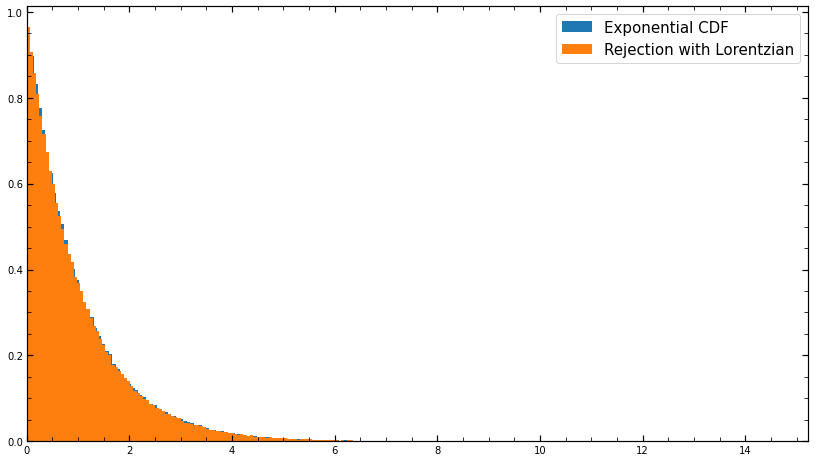

In [13]:
non_neg_lorentz_devs=lorentz_devs[lorentz_devs>0] # cutoff distribution at 0
exp_from_lorentz_CDFinv=exp_from_lorentz(non_neg_lorentz_devs) # generate exp deviates from lorentzian
exp_CDF_inv=exp_CDFinv(len(exp_from_lorentz_CDFinv)) # alternatively np.random.exponential(size=len(exp_from_lorentz_CDF))

fig, ax = plt.subplots(figsize=[14,8])
ax.hist(exp_from_lorentz_CDFinv, bins=200, density=True, label='Exponential CDF')
ax.hist(exp_CDF_inv, bins=200, density=True, label='Rejection with Lorentzian')
ax.set_xlim(xmin=0)
ax.legend(fontsize=15);
print("Fraction of deviates accepted:", len(exp_from_lorentz_CDFinv)/len(non_neg_lorentz_devs))

The fraction of uniform devaites that give rise to exponential deviates was maximized to be $\approx 0.64$.

# Q3) Repeat problem 2, but now use a ratio-of-uniforms generator. If $u$ goes from 0 to 1, what are your limits on $v$? How efficient is this generator in terms of number of exponential deviates produced per uniform deviate? Make sure to plot the histogram again and show it still produces the correct answer.

We can follow the algorithm outline in the lecture slides, in which we enforce the condition that $0 \leq u \leq \sqrt{\lambda e^{-\lambda\frac{v}{u}}}$, where we can take $\lambda=1$, and $u,v$ are randomly sampled from the uniform distribution on the interval $[0,1]$. Rearranging the above formula for the restriction on $u$ in terms of $v$, we get, 

\begin{equation}
0 \leq u^2 \leq \lambda e^{-\lambda \frac{v}{u}} \,\,\,\, \implies \,\, 0 \leq v \leq \frac{-u}{\lambda}\text{ln}\left(\frac{u^2}{\lambda}\right)
\end{equation}

so for $u$ bounded by $[0,1]$, we know that $v$ is bounded from below by $0$, and achieves a maximum on the interval $[0,1]$ at $x = \frac{1}{e}$,  

\begin{equation}
\frac{dv}{du} = \text{ln}\left(\frac{1}{u^2}\right) - 2 = 0 \,\,\, \implies \,\,\, \text{max}_{u \in [0,1]} v = \left(\frac{1}{e}\right)\text{ln}(e^2) = \frac{2}{e}
\end{equation}

Therefore, $v \in [0,2/e]$. Returning the ratio $v/u$ after applying their respective bounds will produce exponentially distributed deviates. 

In [70]:
def ratio_uniforms(n):
    u = np.random.rand(n) # uniform sampling of [0,1]
    v = np.random.uniform(low=0.0, high=(2/np.e), size=n) # enforce bounds [0,2/e]
    u_upper_bnd = np.sqrt(exp(v/u)) # e^(-0.5 v/u)
    ratio = v/u
    ratio_bnd = ratio[u<u_upper_bnd]
    return ratio_bnd

The number of exponential deviates per uniform deviate is:  0.679624


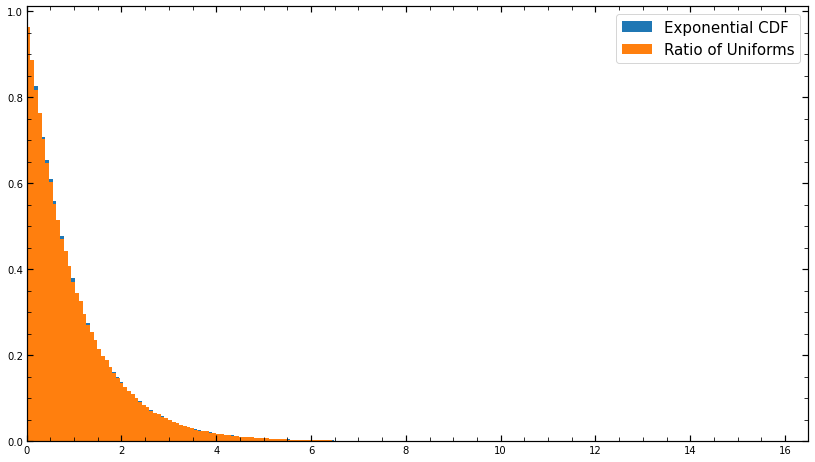

In [71]:
n=1000000
exp_devs_ratio = ratio_uniforms(n)
exp_CDFinv1 = np.random.exponential(scale=1.0, size=len(exp_devs_ratio))
fig,ax = plt.subplots(figsize=[14,8])
ax.hist(exp_CDFinv1, bins=200, density=True, label='Exponential CDF')
ax.hist(exp_devs_ratio, bins=200, density=True, label='Ratio of Uniforms')
ax.set_xlim(xmin=0)
ax.legend(fontsize=15);
print('The number of exponential deviates per uniform deviate is: ', len(exp_devs_ratio)/n)

Clearly, the two histograms match very well.

In [66]:
2*np.random.rand(n)-1

array([-0.09221796, -0.06757567,  0.70229118, ...,  0.67975409,
        0.98232801,  0.52949209])

max v is  0.8577638827689564


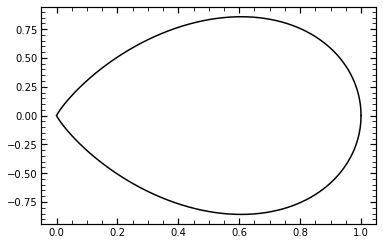

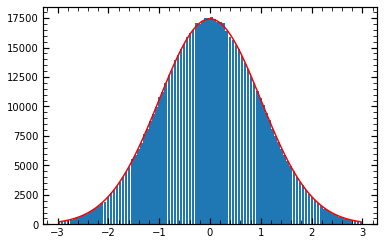

In [67]:

u=np.linspace(0,1,2001)
u=u[1:]
#have u<exp(-0.25*r^2) so
#log(u)=-0.25(v/u)^2
#v=2u*(-log(u))**0.5

v=2*u*np.sqrt(-np.log(u))
print('max v is ',v.max())

plt.ion()
plt.figure(1)
plt.clf()
plt.plot(u,v,'k')
plt.plot(u,-v,'k')
plt.show()

N=1000000
u=np.random.rand(N)
v=(np.random.rand(N)*2-1)*0.86
r=v/u
accept=u<np.exp(-0.25*r**2)
gauss=r[accept]

a,b=np.histogram(gauss,100,range=(-3,3))
bb=0.5*(b[1:]+b[:-1])
pred=np.exp(-0.5*bb**2)/np.sqrt(2*np.pi)*np.sum(accept)*(bb[2]-bb[1])
plt.figure(2)
plt.clf()
plt.bar(bb,a,0.05)
plt.plot(bb,pred,'r')
plt.show()
